# Cat and Dog Image Classification - 98% Training Accuracy

#### This notebook explores the classification of cat and dog images using a Convolutional Neural Network (CNN) implemented in Keras. It includes data preprocessing, model building, training, evaluation, and visualization of results. Overfitting is observed due to a large discrepancy between training and validation accuracy, leading to the decision to create a new notebook to address this issue.

**Libraries**: Numpy, TensorFlow, Keras, Matplotlib, scikit-learn.

**Data**: The training and test datasets consist of cat and dog images.

**Model**: A simple CNN architecture is used for image classification.

**Results**: The model achieves high training accuracy but shows overfitting, indicating the need for further optimization.






# Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import os
import PIL
import shutil
import random
import glob
import itertools
import warnings

warnings.simplefilter(action ='ignore', category=FutureWarning)
%matplotlib inline

2024-03-03 04:40:35.776738: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 04:40:35.776895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 04:40:35.934026: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Data

In [2]:
train_dir = "/kaggle/input/cat-and-dog/training_set/training_set"
test_dir = "/kaggle/input/cat-and-dog/test_set/test_set"

def count_images_in_folders(directory):
    folders = os.listdir(directory)
    for folder in folders:
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            images_count = len(os.listdir(folder_path))
            print(f"Folder: {folder}, Images Count: {images_count}")

print("Train Set:")
count_images_in_folders(train_dir)

print("\nTest Set:")
count_images_in_folders(test_dir)

Train Set:
Folder: dogs, Images Count: 4006
Folder: cats, Images Count: 4001

Test Set:
Folder: dogs, Images Count: 1013
Folder: cats, Images Count: 1012


# Data Preparation

## Create Validation dataset

In [3]:
valid_dir = "/kaggle/working/validation_set"
new_test_dir = "/kaggle/working/new_test_set"

# Create validation directory if not exists
os.makedirs(valid_dir, exist_ok=True)

# Function to copy files
def copy_files(src_dir, dst_dir, category, num_files):
    os.makedirs(os.path.join(dst_dir, category), exist_ok=True)
    files = os.listdir(os.path.join(src_dir, category))
    num_files_to_copy = min(num_files, len(files))
    files_to_copy = files[:num_files_to_copy]
    for file in files_to_copy:
        src_path = os.path.join(src_dir, category, file)
        dst_path = os.path.join(dst_dir, category, file)
        shutil.copy(src_path, dst_path)
        
# Copy 500 cats and 500 dogs from test set to validation set
copy_files(test_dir, valid_dir, 'cats', 500)
copy_files(test_dir, valid_dir, 'dogs', 500)

In [4]:
print("Train Set:")
count_images_in_folders(train_dir)

print("Valid_dir:")
count_images_in_folders(valid_dir)

print("Test Set:")
count_images_in_folders(test_dir)

Train Set:
Folder: dogs, Images Count: 4006
Folder: cats, Images Count: 4001
Valid_dir:
Folder: dogs, Images Count: 500
Folder: cats, Images Count: 500
Test Set:
Folder: dogs, Images Count: 1013
Folder: cats, Images Count: 1012


## Setting ImageDataGenerator to ensure the imported libraries before modelling

In [5]:
# Define the image size and batch size
image_size = (224, 224)
batch_size = 10

# Create an ImageDataGenerator for preprocessing
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

# Create the train_batches using flow_from_directory
train_batches = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=['cats', 'dogs']
)

# Create the test_batches using flow_from_directory
test_batches = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=['cats', 'dogs']
)

# Create the valid_batches using flow_from_directory
valid_batches = datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=['cats', 'dogs']
)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Found 998 images belonging to 2 classes.


In [6]:
assert train_batches.n == 8005
assert test_batches.n == 2023
assert valid_batches.n == 998
assert train_batches.num_classes == test_batches.num_classes == valid_batches.num_classes == 2

## Seperate labels with images for training 

In [7]:
imgs, labels = next(train_batches)

# Data Visualization

### Post preprocess visualization with vgg16

In [8]:
def plotImages(images_arr) :
    fig, axes = plt.subplots(1, 10, figsize = (20,20))
    axes = axes. flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

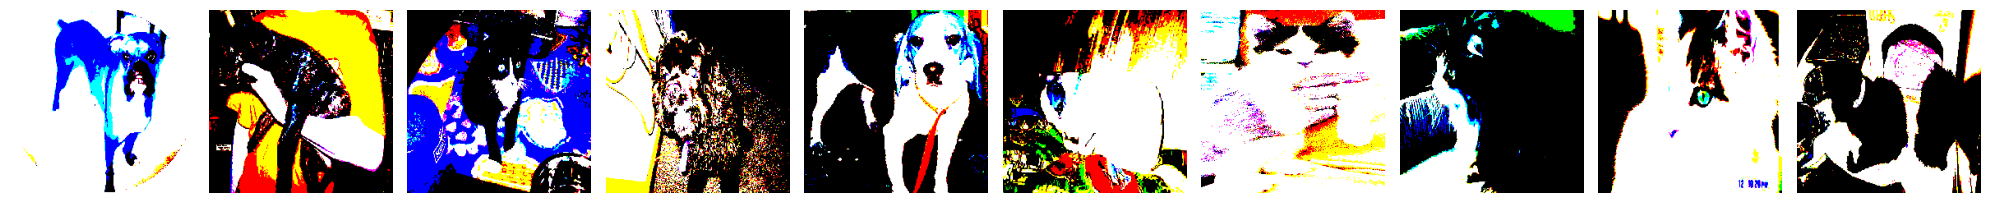

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [9]:
plotImages(imgs)
print(labels)

# Build and Train CNN

## Create Model

In [10]:
model = Sequential([
  Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(224,224,3)),
  MaxPool2D(pool_size=(2,2), strides=2),
  Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
  MaxPool2D(pool_size=(2,2), strides=2),
  Flatten(),
  Dense(units=2, activation='softmax'),
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


## Summary Model

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │       401,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 420,802 (1.61 MB)

 Trainable params: 420,802 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

## Compile Model

In [12]:
model.compile(optimizer= Adam(learning_rate = 0.0001),
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

## Fitting Model

In [13]:
model.fit(
  x=train_batches,
  validation_data=valid_batches,
  epochs=10,
  verbose=2
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


801/801 - 363s - 453ms/step - accuracy: 0.6230 - loss: 4.3740 - val_accuracy: 0.6473 - val_loss: 0.7683
Epoch 2/10
801/801 - 358s - 447ms/step - accuracy: 0.8602 - loss: 0.3321 - val_accuracy: 0.6693 - val_loss: 0.8586
Epoch 3/10
801/801 - 377s - 471ms/step - accuracy: 0.9684 - loss: 0.1018 - val_accuracy: 0.6683 - val_loss: 1.0704
Epoch 4/10
801/801 - 386s - 481ms/step - accuracy: 0.9926 - loss: 0.0390 - val_accuracy: 0.6713 - val_loss: 1.2080
Epoch 5/10
801/801 - 380s - 474ms/step - accuracy: 0.9829 - loss: 0.0561 - val_accuracy: 0.6754 - val_loss: 1.3193
Epoch 6/10
801/801 - 356s - 444ms/step - accuracy: 0.9690 - loss: 0.0950 - val_accuracy: 0.6743 - val_loss: 1.3568
Epoch 7/10
801/801 - 383s - 478ms/step - accuracy: 0.9726 - loss: 0.0765 - val_accuracy: 0.6834 - val_loss: 1.3155
Epoch 8/10
801/801 - 382s - 476ms/step - accuracy: 0.9829 - loss: 0.0479 - val_accuracy: 0.6633 - val_loss: 1.5458
Epoch 9/10
801/801 - 384s - 479ms/step - accuracy: 0.9874 - loss: 0.0371 - val_accuracy: 0.

### The model is performing very well with 98% accuracy.
### There is overfitting because validation accuracy << training accuracy. Since, this notebook is a Keras Starter, new notebook will be created to overcome overfitting.

# Model Prediction 

In [14]:
predictions = model.predict(x=test_batches, verbose=0)

In [15]:
np.round(predictions)

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

# Create Confusion Matrix

In [16]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          text_color='black'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color=text_color)  # Change text color here
                 #color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [18]:
test_batches.class_indices

{'cats': 0, 'dogs': 1}

Confusion matrix, without normalization


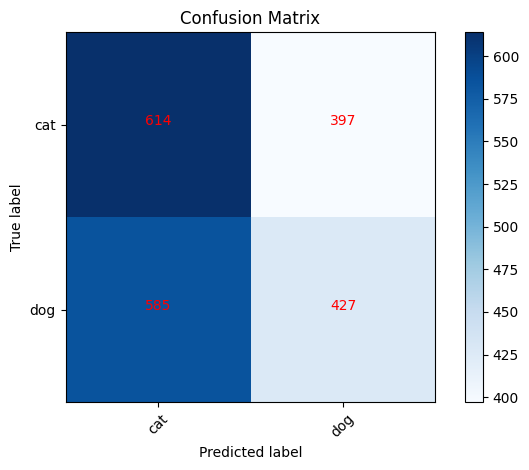

In [19]:
cm_plot_label = ['cat', 'dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_label, title='Confusion Matrix', text_color='red')